# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


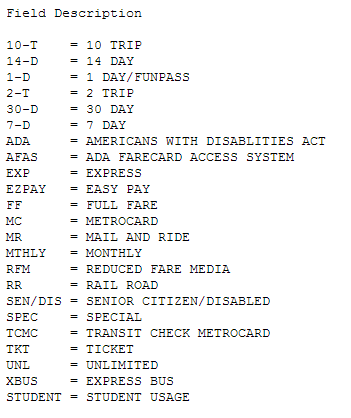

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [5]:
# @method get_data
# @method remove_outlier
# @method get_stats 
class PandasDataLoader():
    def __init__(self, data):
        try:
            self.__data = data
            self.__buffer = data.copy(deep=True)
        except ValueError:
            print("Error: Instance Initialization Failed")
    def get_data(self):
        try:
            return self.__buffer
        except ValueError:
            print("Error: Unable To Retrieve Data")
    def remove_outlier(self, dimension):
        try:
            lower, upper = np.mean(self.data.dimension) - 3 * self.data.dimension.std(), \
            p.mean(self.data.dimension) + 3 * self.data.dimension.std()
            return self.data[(self.data.dimension < upper) & (self.data.dimension > lower)]
        except ValueError:
            print("Error: Unable to Remove Outlier")
    def get_stats(self):
        try:
            return self.data.describe()
        except ValueError:
            print("Error: Unable to Obtain Stats.") 

In [14]:
class ArrayDataLoader():
    # intialization construtor 
    def __init__(self, data):
        try:
            self.data = data
            self.buffer = data
        except ValueError:
            print("Initialization Failed.")
    # return self.data 
    def get_data(self):
        try:
            self.buffer = self.buffer.astype('float')
            self.buffer[self.buffer==-1] = 0
            return self.buffer
        except ValueError:
            print("Unable to get data.")
    # same as before but return Nan 
    def get_data_nan(self):
        try:
            self.buffer = self.buffer.astype('float')
            self.buffer[self.buffer==-1] = np.nan
            return self.buffer
        except ValueError:
            print("Unable to get data.")
    # print data summary 
    def summary(self):
        try:
            print("MTA array shape:", self.data.shape)
            print("MTA array shape summed over all ride types:", np.nansum(self.data,axis=1).shape)
        except ValueError:
            print("Cannot get the summary report of the data")
    # plot all data 
    def plot_all_data(self, dataset):
        # figure size
        plt.figure(figsize=(20,6))
        # loop 2d array and plot graph
        for i in range(0, len(dataset)):
            for j in range(0, len(dataset[i])):
                try:
                    mtaRidesPerWeek = pd.DataFrame(dataset[i][j])
                    plt.plot(range(0, 194), np.log10(mtaRidesPerWeek))
                except ValueError:
                    print("Unable to plot the graph")
        # set the title           
        plt.title('time series for all ride types and all stations in semi-log space', fontsize=20)
        plt.xlabel('weeks since 05/21/2010', fontsize=20)
        plt.ylabel('swipes (log10)', fontsize=20)
    # print and return outlier threshood and date 
    def get_outlier(self):
        # dummy dataset 10 10
        mtaRidesPerWeek = pd.DataFrame(np.nansum(np.nansum(mta_rides,axis=0),axis=0),
                               columns=['ride'])
        # mean std of the sample dataset 
        mean, std = mtaRidesPerWeek.ride.mean(), mtaRidesPerWeek.ride.std()
        # index of our target outlier week 
        thresholds = [mean - 3 * std, mean + 3 * std]
        index = mtaRidesPerWeek[(mtaRidesPerWeek.ride < thresholds[1]) |
                (mtaRidesPerWeek.ride > thresholds[0])].index[0]
        # return lower, upper, weekdays of the outlier week 
        return mean - 3 * std, mean + 3 * std, \
    pd.date_range('05/21/2010','02/21/2014',freq='W-FRI')[:-1][index: index + 5]
    # iterate through data and return sum of ith feature at jth week 
    def get_feature(self, type_num, week_num, mta_rides):
        swipe_per_station_per_type = []
        for i in range(0, len(mta_rides)):
            swipe_per_station_per_type.append(mta_rides[i][type_num][week_num])
        return swipe_per_station_per_type
    # non smoothed 
    def get_series_stats_non_smooth(self, i):
        print('-' * 20 )
        print('Series number %d' % (i))
        print('std: %f' % (np.array(rides[i]).std()))
        print('fractional change over time: %f' % (rides[i][193] / rides[i][0]))
        return rides[i][193] / rides[i][0]
    # smoothed 
    def get_series_stats_smooth(self, i):
        rm = mta_rides_df.loc[i].rolling(1).mean()
        print('-' * 20 )
        print('Series number %d' % (i))
        print('std: %f' % (rm.std()))
        print('fractional change over time: %f' % (rm[193] / rm[0]))
        return rm[193] / rm[0]

In [15]:
# @method clean_na 
# @method get_cols
# @method drop_cols
# @method fill_na
class DataCleaner(PandasDataLoader):
    def __init__(self, data):
        try:
            super().__init__(data)
            self.__buffer = data.copy(deep=True)
        except ValueError:
            print("Initialization Failed.")
    def clean_na(self):
        try:
            print("None value count: ")
            print(self.__buffer.isnull().sum())
            self.__buffer = self.__buffer.dropna()
            print("After clean: ")
            print(self.__buffer.isnull().sum())
            return self.__buffer
        except ValueError:
            print("Clean Failed")
    def get_cols(self, array):
        try:
            return self.__buffer[array]
        except ValueError:
            print("Unable to get columns")
    def drop_cols(self, array):
        try:
            return self.__buffer.drop(columns=array)
        except ValueError:
            print("Drop Column failed")
    def fill(self, num=0):
        try:
            return self.__buffer.fillna(num)
        except ValueError:
            print("Cannot fill NULL values")

In [16]:
mta = ArrayDataLoader(np.load("MTA_Fare.npy"))
mta.summary()
# MTA array contains 600 stations
# each station has 23 ride types 
# each ride type has 194 data 

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [17]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [18]:
mta_rides = mta.get_data()

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10


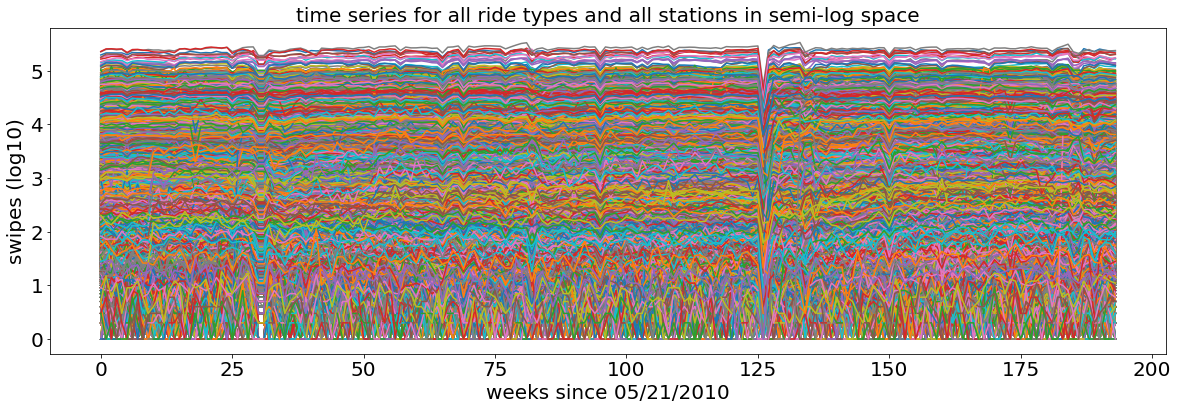

In [112]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
mta.plot_all_data(mta_rides)

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 

#### We can see that around the week of 125, there is a significant drop in the usage of MTA trains. Since it is clearly an outlier, I will retrieve the 3*sigma threshoold and get the index of the date. 

In [19]:
lower, upper, date = mta.get_outlier()
print('lower: %f upper: %f' % (lower, upper))
print('date week index: ', date)

lower: 20806307.166892 upper: 38756392.575376
date week index:  DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18'],
              dtype='datetime64[ns]', freq='W-FRI')


#### At that time, NYC was suffering from the hurricane Sandy. Several subway stations were flooded with water and therefore cannot be used anymore. Therefore, we witness a great drop in the number of riderships.

 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [21]:
# get the rides of type i at week j 
# sum this value to the stack 
rides = []
for t in range(0, 23):
    rides_of_feature = []
    for w in range(0, 194):
        # sum of t feature at w week of all stations 
        rides_of_feature.append(sum(mta.get_feature(t, w, mta_rides)))
    rides.append(rides_of_feature) 
rides = np.array(rides)

In [22]:
# rides have 23 features over 194 weeks 
# each feature is a sum of all station's rides at that given week 
rides.shape

(23, 194)

In [23]:
mta_rides_df = pd.DataFrame(rides)

In [24]:
# get series stats for each series 
# non smoothed 
for i in range(0, len(rides)):
    mta.get_series_stats_non_smooth(i)

--------------------
Series number 0
std: 1212509.303711
fractional change over time: 1.083981
--------------------
Series number 1
std: 90631.594000
fractional change over time: 1.280804
--------------------
Series number 2
std: 7599.227413
fractional change over time: 1.154620
--------------------
Series number 3
std: 17590.591686
fractional change over time: 0.961469
--------------------
Series number 4
std: 12633.837135
fractional change over time: 1.001090
--------------------
Series number 5
std: 763049.861181
fractional change over time: 1.461842
--------------------
Series number 6
std: 1053449.593311
fractional change over time: 1.017916
--------------------
Series number 7
std: 4061.960231
fractional change over time: 0.000000
--------------------
Series number 8
std: 110873.907982
fractional change over time: 0.000009
--------------------
Series number 9
std: 221304.421975
fractional change over time: 0.000002
--------------------
Series number 10
std: 19630.514102
fractiona

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in double_scalars
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars


In [25]:
# smooth rolling mean 
fraction, f = {}, []
for i in range(0, len(rides)):
    f.append(mta.get_series_stats_smooth(i))
    fraction[mta.get_series_stats_smooth(i)] = i 
# print results
print("steepest increase: ", fraction[max(np.array(f))])
print("steepest decrease: ", fraction[min(np.array(f))])

--------------------
Series number 0
std: 1215646.461098
fractional change over time: 1.083981
--------------------
Series number 0
std: 1215646.461098
fractional change over time: 1.083981
--------------------
Series number 1
std: 90866.087520
fractional change over time: 1.280804
--------------------
Series number 1
std: 90866.087520
fractional change over time: 1.280804
--------------------
Series number 2
std: 7618.889095
fractional change over time: 1.154620
--------------------
Series number 2
std: 7618.889095
fractional change over time: 1.154620
--------------------
Series number 3
std: 17636.104289
fractional change over time: 0.961469
--------------------
Series number 3
std: 17636.104289
fractional change over time: 0.961469
--------------------
Series number 4
std: 12666.524996
fractional change over time: 1.001090
--------------------
Series number 4
std: 12666.524996
fractional change over time: 1.001090
--------------------
Series number 5
std: 765024.120266
fractional c

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in double_scalars


### So from the results we can conclude that 22th series is the one with steepest increase while the 7th series is the one with steepest decrease.

Text(0.5, 1.0, 'Week vs. swipes of 22th type with steepest increase')

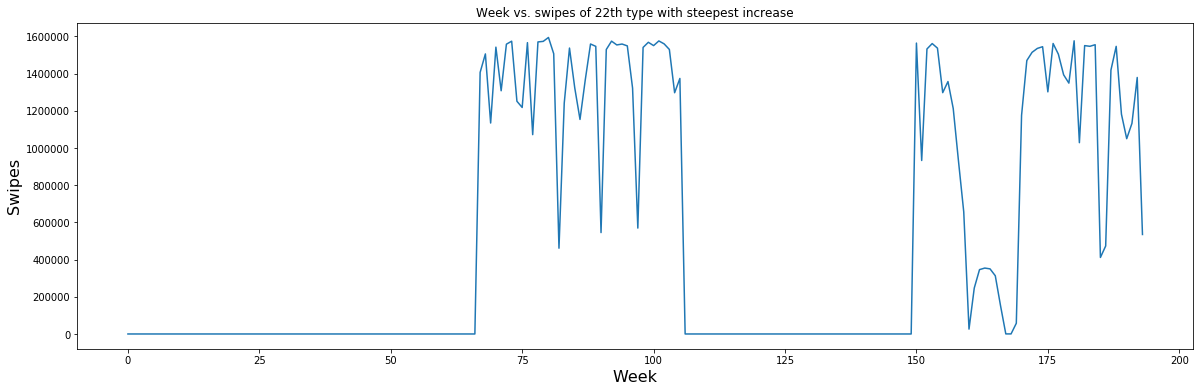

In [26]:
plt.figure(figsize=(20,6))
plt.plot(range(194), rides[22])
plt.xlabel('Week', fontsize=16)
plt.ylabel('Swipes', fontsize=16)
plt.title('Week vs. swipes of 22th type with steepest increase')

Text(0.5, 1.0, 'Week vs. swipes of 7th type with steepest decrease')

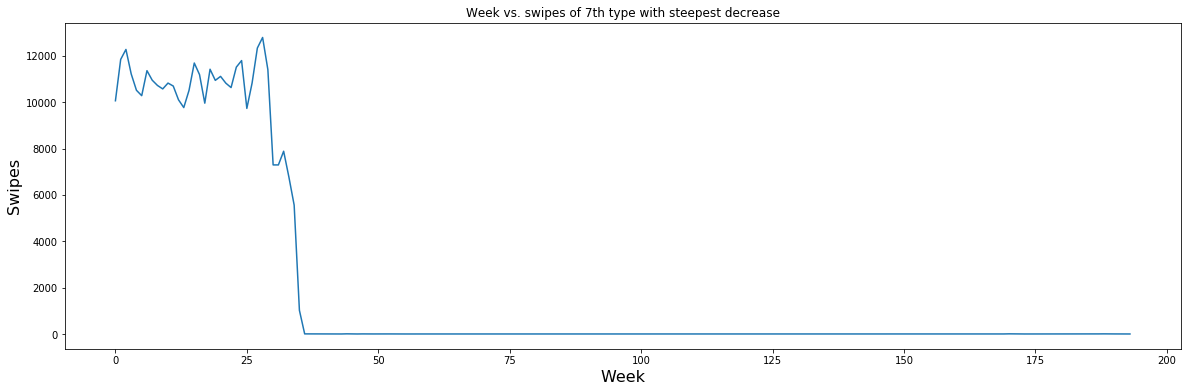

In [27]:
plt.figure(figsize=(20,6))
plt.plot(range(194), rides[7])
plt.xlabel('Week', fontsize=16)
plt.ylabel('Swipes', fontsize=16)
plt.title('Week vs. swipes of 7th type with steepest decrease')

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [55]:
mod = 9317 // 23
label, lb = [], [i for i in range(0,23)]
for i in range(0, mod):
    label.extend(lb)
label.extend(lb[:9317-mod*23])
label = np.array(label)

In [56]:
label.shape

(9317,)

In [57]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2])

In [58]:
mtd = ArrayDataLoader(np.load("MTA_Fare.npy"))
data_mta = mtd.get_data()
data_mta_nan = mtd.get_data_nan()

In [59]:
stationsmeans = []
for i in range(0, len(data_mta)):
    stationsmeans.append(np.mean(data_mta[i].flatten()))
stationsmeans = np.array(stationsmeans)

In [60]:
stationsmeans.shape

(600,)

In [61]:
stationstd = []
for i in range(0, len(data_mta)):
    stationstd.append(np.std(data_mta[i].flatten()))
stationstd = np.array(stationstd)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [168]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[data_mta_nan.reshape(600*23, 194).std(1) > 0]

array([  0,   0,   0, ..., 550, 550, 550])

In [63]:
tots = data_mta_nan.reshape(600*23,194)[:9317]
tots.shape

(9317, 194)

In [68]:
tots_df = pd.DataFrame(tots)
# normalization 
norm_mean, norm_std = [], []
for i in range(0, 9317):
    norm_mean.append(tots_df.loc[i].mean() / stationsmeans[i // 23])
    norm_std.append(tots_df.loc[i].std() / stationstd[i // 23])

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [69]:
normed_time_series_mean = norm_mean
normed_time_series_std = norm_std

In [70]:
normed_time_series_std[:10]

[1.325218993744574,
 0.03846284693721661,
 0.005006397022737778,
 0.01426612275996916,
 0.0101835378806048,
 0.4438361194269652,
 0.7425062390523456,
 0.0013269564915761945,
 0.16392851225805438,
 0.0702399953538609]

In [71]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(9317,)

In [72]:
tsmean[:10]

array([5.79828969e+04, 1.80933505e+03, 2.34876289e+02, 7.30051546e+02,
       2.90118557e+02, 1.98267784e+04, 3.02422732e+04, 8.48453608e+00,
       9.67097938e+02, 4.26835052e+02])

In [75]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(9317,)

In [76]:
tsstdev[:10]


array([18633.98148959,   540.82833196,    70.39524025,   200.59678339,
         143.19131952,  6240.80553694, 10440.42349205,    18.65841255,
        2305.00836273,   987.64866745])

In [85]:
standardizedts = []
for i in range(0, 9317):
    data = []
    data.append((tots_df.loc[i] - tsmean[i]) / tsstdev[i])
    standardizedts.append(np.array(data).reshape(194,))
standardizedts = np.array(standardizedts)

Text(0, 0.5, 'standardized number of rides')

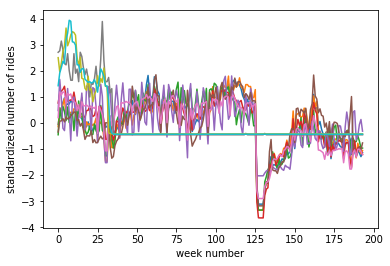

In [87]:
# plot the data 
for i in range(10):
    pl.plot(range(194), standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [216]:
# na removal 
index = []
for i in range(0, len(standardizedts)):
    for j in range(0, len(standardizedts[i])):
        if np.isnan(standardizedts[i][j]) or standardizedts[i][j] == float('Inf') \
        or standardizedts[i][j] == -float('Inf'):
            index.append(i)
index = np.unique(np.array(index))
# get good ones 
X,Y = [],[]
for i in range(0, len(standardizedts)):
    if i not in index:
        X.append(standardizedts[i])
        Y.append(label[i])
    else:
        continue 

In [232]:
'''
For here I believe we're supposed to use the standardized data 
'''
allfits = []
for i in range(0, len(X)):
    x, y = X[i], Y[i]
    md = sm.OLS([y], [x]).fit()
    allfits.append(md)
    if (i % 500 == 0):
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


In [233]:
[a.params[0] for a in allfits[:10]]

[0.0,
 -0.0007370809973637057,
 -0.004668235116445049,
 0.011790728805705308,
 0.009774456945509803,
 -0.008973111194087221,
 0.006300037143867714,
 0.09768906760881814,
 0.10315327312223925,
 0.06614420899824006]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [246]:
d1, d2 = tsmean/norm_mean, tsstdev/norm_std
cd1, cd2 = [], []
for i in range(len(d1)):
    if not i in index:
        cd1.append(d1[i])
        cd2.append(d2[i])
    else:
        continue

X_train, X_test, y_train, y_test = train_test_split(
    
    np.array(
        
        [[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              cd1, cd2]
    ).T,
    
    
    Y, test_size=0.33, random_state=42, shuffle=True)

/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/nfshome/ty1045/.conda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [247]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5165, 4), (2544, 4), (5165,), (2544,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [249]:
'''
I already taken care of the invalid values before 
'''
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [250]:
'''
I already taken care of the invalid values before 
'''
#X_train[~np.isfinite(X_train)] = # ... make a choice about what to do with this datapoint. drop it or replace it with something

'\nI already taken care of the invalid values before \n'

In [253]:
clf = rfc(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [255]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

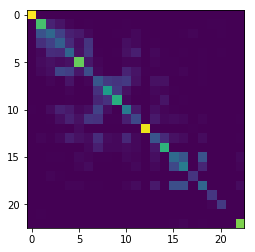

In [256]:
imshow(confusion_matrix(y_test, y_pred))

 and use classification_report to assess the model and clf.feature_importances_ to find the important features

## Build a model that uses as input features each time stamp (194 features) :


In [87]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(
    

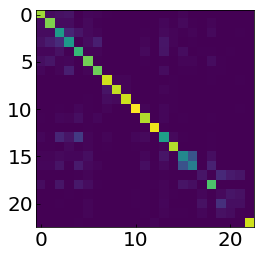

In [90]:
imshow(confusion_matrix(y_test, y_pred))

In [91]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.75      0.82      0.78       160
        14d       0.75      0.79      0.77       157
         1d       0.50      0.60      0.55       141
         2t       0.55      0.54      0.55       154
        30d       0.59      0.73      0.65       142
         7d       0.71      0.79      0.74       154
        ada       0.82      0.81      0.81       149
       afas       0.88      0.95      0.92       150
        exp       0.96      0.92      0.94       153
         ez       0.97      0.92      0.95       154
         ff       0.96      0.92      0.94       168
         mc       0.82      0.87      0.84       157
         mr       0.97      0.99      0.98       152
      month       0.57      0.55      0.56       159
        rfm       0.88      0.90      0.89       151
         rr       0.53      0.48      0.50       151
        sen       0.55      0.40      0.46       162
       spec       0.39      0.17      0.24   